In [1]:
import pandas as pd
import numpy as np
import sklearn
import json
from pandas import DataFrame
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, IsolationForest
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.neighbors import KNeighborsRegressor, LocalOutlierFactor, NearestNeighbors
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, r2_score, max_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split, cross_validate, StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.svm import OneClassSVM
from sklearn import preprocessing

In [2]:
# chemical_composition = ['C', 'Si', 'Mn', 'Cu', 'Ni', 'Mo','Cr', 'V']
chemical_composition = ['C', 'Si', 'Mn', 'Mg', 'Cu', 'Ni', 'Mo', 'S', 'P', 'Cr', 'V']
heat_treatment = ['aust_temp', 'aust_czas', 'ausf_temp', 'ausf_czas']
physical_properties = ['Rm', 'Rp02', 'A5', 'HB', 'K']
additional_features = ['grubosc']
all_cols = chemical_composition + heat_treatment + physical_properties + additional_features

In [3]:
excel_data_path = "../../magisterka/zebrane-dane.xlsx"

In [29]:
df = pd.read_excel(excel_data_path, sheet_name="Dane", header=1, usecols=all_cols)
df

,C,Si,Mn,Mg,Cu,Ni,Mo,S,P,V,...,aust_temp,aust_czas,ausf_temp,ausf_czas,Rm,Rp02,A5,HB,K,grubosc
0,3.40,2.30,0.17,0.047,0.70,1.50,0.24,0.010,0.034,0.0,...,900,120,240,120,1507.0,1072.0,2.8,429.0,54.4,25
1,3.40,2.30,0.17,0.047,0.70,1.50,0.24,0.010,0.034,0.0,...,900,120,270,120,1307.0,936.0,4.1,388.0,71.6,25
2,3.40,2.30,0.17,0.047,0.70,1.50,0.24,0.010,0.034,0.0,...,900,120,310,120,1132.0,804.0,5.4,341.0,84.4,25
3,3.40,2.30,0.17,0.047,0.70,1.50,0.24,0.010,0.034,0.0,...,900,120,360,120,1028.0,652.0,10.0,285.0,123.6,25
4,3.52,2.87,0.22,0.051,0.73,1.55,0.00,0.017,0.650,0.0,...,850,120,390,90,1064.9,NaN,15.4,296.8,NaN,25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
684,3.97,1.57,0.49,0.059,0.00,0.00,0.00,0.010,0.003,0.0,...,850,30,370,60,NaN,NaN,NaN,NaN,51.0,25
685,3.97,1.57,0.49,0.059,0.00,0.00,0.00,0.010,0.003,0.0,...,850,30,400,60,NaN,NaN,NaN,NaN,30.0,25
686,3.97,1.57,0.49,0.059,0.00,0.00,0.00,0.010,0.003,0.0,...,950,15,340,60,NaN,NaN,NaN,NaN,28.0,25
687,3.97,1.57,0.49,0.059,0.00,0.00,0.00,0.010,0.003,0.0,...,950,15,370,60,NaN,NaN,NaN,NaN,48.5,25


In [5]:
def evaluate(model, X, y, label= "", save_predictions=False):
    print('Model Performance')
    pred_train_rf= model.predict(X)
    print('{} RMSE = {:0.2f}.'.format(label, np.sqrt(mean_squared_error(y,pred_train_rf))))
    print('{} RMAE = {:0.2f}.'.format(label, np.sqrt(mean_absolute_error(y,pred_train_rf))))
    print('{} Max error  = {:0.2f}.'.format(label, max_error(y, pred_train_rf)))
    print('{} R2 = {:0.2f}.'.format(label, r2_score(y, pred_train_rf)))
    if save_predictions:
        train = pd.DataFrame()
        train['y'] = y
        train['y_pred'] = pred_train_rf
        train.to_csv("{}_y_comp_rf.csv".format(label))

In [19]:
amount_of_feats_to_reg = 3
req_neighs = 15
df['log_10(ausf_czas_sec)'] = df.apply(lambda row: np.log10(row['ausf_czas']*60), axis=1)
important_features = set(['Mn', 'Cu', 'Ni', 'Mo'] + heat_treatment + additional_features)

In [17]:
def get_n_correlated_features_without(corrs, n, without):
    correlated_to_check = list(corrs.sort_values(ascending=False).index.values[1:])
    correlated = []
    for corr in correlated_to_check:
        if len(correlated) < n and corr not in without:
            correlated.append(corr)
    return correlated

def get_features_above_corr_coef(corrs, value):
    above_0_5 = []
    for index, corr in corrs.map(abs).items():
        if corr >= value:
            above_0_5.append(index)
    return above_0_5   

def fill(row, prop, df):
    if not np.isnan(row[prop]):
        return [row[prop], None, None, None, None, None]
    nan_features = list(row[row.isnull()].index.values)
    nan_features.remove(prop)
    correlated = get_n_correlated_features_without(df.corr()[prop].map(abs), amount_of_feats_to_reg, nan_features)
    not_correlated = set(df.columns) - set(correlated)
    not_correlated.discard('log_10(ausf_czas_sec)')
    not_correlated = set(df[not_correlated].dropna(axis=1).columns)
    not_correlated = not_correlated.intersection(important_features)
    X = df[not_correlated].values
    scaler = MinMaxScaler().fit(X)
    X = scaler.transform(X)
    neighs = req_neighs
    while True:
        nbrs = NearestNeighbors(n_neighbors=neighs, algorithm = 'brute').fit(X)
        index_to_reg = list(nbrs.kneighbors(scaler.transform([row[not_correlated]]))[1][0][1:])
        df_to_reg = df.iloc[index_to_reg]
        df_to_reg = df_to_reg.dropna(subset=correlated+[prop])
        if df_to_reg.shape[0] >= req_neighs:
            break
        neighs+=5
    corrs = df_to_reg.corr()[prop][correlated]
    correlated = get_features_above_corr_coef(corrs, 0.7)
    if correlated == []:
        return [None, None, None, None, None, None]
    to_reg_X, to_reg_y = df_to_reg[correlated].values, df_to_reg[prop].values
    reg_model = LinearRegression().fit(to_reg_X, to_reg_y)
    return [reg_model.predict([row[correlated].values])[0], not_correlated, df_to_reg.shape[0], list(corrs[correlated].index.values), list(corrs[correlated].values), [min(to_reg_y), max(to_reg_y)]]
    

def impute_missing(prop, df: DataFrame):
    return df.apply(axis=1, func=fill, args=[prop, df], result_type='expand')

In [30]:
order = ['Rm', 'HB', 'Rp02', 'A5', 'K']
df_filled = df.copy()

step = 1
while True:
    print('Step {}'.format(step))
    filled = 0
    for prop in order:
        if df_filled.describe()[prop].loc['count'] == df_filled.shape[0]:
            filled+=1
            continue
        df_new = DataFrame()
        df_new[prop] = df_filled[prop]
        returned_cols = [prop + '_imp', 'Features to find neighs', 'Amount of neighs', 'Correlated features', 'Correlation coefficients', 'Min_max']
        df_new[returned_cols] = impute_missing(prop, df_filled)
        print('Finished imputing for {}'.format(prop))
        with pd.ExcelWriter(excel_data_path, mode='a') as writer:
            df_new.to_excel(writer, sheet_name="imputed_{}_{}".format(prop, step))
        df_filled[prop] = df_new[prop + '_imp']
    if filled == len(order) or step >= 5:
        break
    step+=1

df_filled

Step 1
Finished imputing for Rm
Finished imputing for HB
Finished imputing for Rp02
Finished imputing for A5
Finished imputing for K
Step 2
Finished imputing for Rm
Finished imputing for HB
Finished imputing for Rp02
Finished imputing for A5
Finished imputing for K
Step 3
Finished imputing for HB
Finished imputing for A5
Finished imputing for K
Step 4
Finished imputing for HB
Finished imputing for A5
Finished imputing for K
Step 5
Finished imputing for A5
Finished imputing for K


,C,Si,Mn,Mg,Cu,Ni,Mo,S,P,V,...,aust_temp,aust_czas,ausf_temp,ausf_czas,Rm,Rp02,A5,HB,K,grubosc
0,3.40,2.30,0.17,0.047,0.70,1.50,0.24,0.010,0.034,0.0,...,900,120,240,120,1507.000000,1072.000000,2.800000,429.000000,54.4,25
1,3.40,2.30,0.17,0.047,0.70,1.50,0.24,0.010,0.034,0.0,...,900,120,270,120,1307.000000,936.000000,4.100000,388.000000,71.6,25
2,3.40,2.30,0.17,0.047,0.70,1.50,0.24,0.010,0.034,0.0,...,900,120,310,120,1132.000000,804.000000,5.400000,341.000000,84.4,25
3,3.40,2.30,0.17,0.047,0.70,1.50,0.24,0.010,0.034,0.0,...,900,120,360,120,1028.000000,652.000000,10.000000,285.000000,123.6,25
4,3.52,2.87,0.22,0.051,0.73,1.55,0.00,0.017,0.650,0.0,...,850,120,390,90,1064.900000,813.153769,15.400000,296.800000,NaN,25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
684,3.97,1.57,0.49,0.059,0.00,0.00,0.00,0.010,0.003,0.0,...,850,30,370,60,987.699754,742.920837,4.855673,277.204479,51.0,25
685,3.97,1.57,0.49,0.059,0.00,0.00,0.00,0.010,0.003,0.0,...,850,30,400,60,873.691072,663.914094,4.360601,257.748136,30.0,25
686,3.97,1.57,0.49,0.059,0.00,0.00,0.00,0.010,0.003,0.0,...,950,15,340,60,1084.916837,822.883962,3.002316,371.529728,28.0,25
687,3.97,1.57,0.49,0.059,0.00,0.00,0.00,0.010,0.003,0.0,...,950,15,370,60,959.123719,735.263677,4.071425,313.240990,48.5,25


In [ ]:
df_filled.describe()

In [ ]:
with pd.ExcelWriter(excel_data_path,
                    mode='a') as writer:
    df_new_rm.to_excel(writer, sheet_name="imputed")

In [23]:
df['ausf_czas_2'] = df.apply(lambda row: row['ausf_czas']**4, axis=1)
df

,C,Si,Mn,Mg,Cu,Ni,Mo,S,P,V,...,aust_czas,ausf_temp,ausf_czas,Rm,Rp02,A5,HB,K,grubosc,log_10(ausf_czas_sec)
count,711.000000,711.000000,711.000000,711.000000,711.000000,711.000000,711.000000,711.000000,711.000000,711.000000,...,711.000000,711.000000,711.000000,711.000000,711.000000,650.000000,710.000000,692.000000,711.000000,711.000000
mean,3.482267,2.468509,0.245526,0.051046,0.582959,0.757358,0.080327,0.011460,0.034224,0.000852,...,94.774965,335.552743,135.053446,1132.380020,914.584039,5.734204,348.332852,82.231034,28.803094,3.768979
std,0.166609,0.223651,0.098214,0.029140,0.572900,0.634207,0.117780,0.006368,0.075171,0.005667,...,38.686424,43.394421,147.029622,192.603586,210.893653,3.563061,55.001321,38.271770,13.540676,0.339365
min,3.070000,1.570000,0.061000,0.020000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,15.000000,240.000000,10.000000,588.000000,379.000000,-17.596499,180.529925,-17.005376,13.000000,2.778151
25%,3.400000,2.320000,0.180000,0.042000,0.002000,0.090000,0.000000,0.008000,0.015000,0.000000,...,60.000000,300.000000,60.000000,998.500000,774.000000,3.228295,309.412122,57.500000,25.000000,3.556303
50%,3.500000,2.500000,0.230000,0.048000,0.500000,0.820000,0.010000,0.010000,0.022000,0.000000,...,90.000000,340.000000,120.000000,1116.000000,889.010873,5.500000,341.690325,78.578873,25.000000,3.857332
75%,3.580000,2.570000,0.300000,0.055000,1.000000,1.500000,0.150000,0.013000,0.029000,0.000000,...,120.000000,370.000000,180.000000,1261.429772,1051.877018,7.900000,388.136764,106.000000,25.000000,4.033424
max,3.970000,3.090000,0.610000,0.500000,1.600000,1.900000,0.500000,0.125000,0.650000,0.050000,...,180.000000,450.000000,1440.000000,1657.000000,1655.779514,19.900000,498.000000,255.500000,100.000000,4.936514


In [24]:
with pd.ExcelWriter(excel_data_path,
                    mode='a') as writer:
    df_new_rm.to_excel(writer, sheet_name="imputed")

NameError: name 'df_new_rm' is not defined

In [93]:
df['ausf_czas_2'] = df.apply(lambda row: row['ausf_czas']**4, axis=1)
df

,C,Si,Mn,Mg,Cu,Ni,Mo,S,P,Cr,...,ausf_czas,Rm,Rp02,A5,HB,K,grubosc,aust_temp_2,ausf_temp_2,ausf_czas_2
0,3.40,2.30,0.17,0.047,0.70,1.50,0.24,0.010,0.034,0.0,...,120,1507.0,1072.0,2.8,429.0,54.4,25,810000.0,57600.0,2.073600e+08
1,3.40,2.30,0.17,0.047,0.70,1.50,0.24,0.010,0.034,0.0,...,120,1307.0,936.0,4.1,388.0,71.6,25,810000.0,72900.0,2.073600e+08
2,3.40,2.30,0.17,0.047,0.70,1.50,0.24,0.010,0.034,0.0,...,120,1132.0,804.0,5.4,341.0,84.4,25,810000.0,96100.0,2.073600e+08
3,3.40,2.30,0.17,0.047,0.70,1.50,0.24,0.010,0.034,0.0,...,120,1028.0,652.0,10.0,285.0,123.6,25,810000.0,129600.0,2.073600e+08
4,3.52,2.87,0.22,0.051,0.73,1.55,0.00,0.017,0.650,0.0,...,90,1064.9,NaN,15.4,296.8,NaN,25,722500.0,152100.0,6.561000e+07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
471,3.07,2.15,0.26,0.043,1.60,1.50,0.00,0.010,0.020,0.0,...,60,1131.0,NaN,5.3,NaN,46.0,25,810000.0,122500.0,1.296000e+07
472,3.07,2.15,0.26,0.043,1.60,1.50,0.00,0.010,0.020,0.0,...,120,1128.5,NaN,9.9,NaN,89.5,25,810000.0,122500.0,2.073600e+08
473,3.07,2.15,0.26,0.043,1.60,1.50,0.00,0.010,0.020,0.0,...,180,1082.5,NaN,11.1,NaN,121.5,25,810000.0,122500.0,1.049760e+09
474,3.07,2.15,0.26,0.043,1.60,1.50,0.00,0.010,0.020,0.0,...,240,1041.5,NaN,10.1,NaN,105.0,25,810000.0,122500.0,3.317760e+09


In [111]:
df_new = DataFrame()
to_impute = physical_properties
df_tmp = df.query("obrobka_produkcyjna==1")
for prop in to_impute:
    print(prop)
    df_new[prop] = impute_missing(prop, df_tmp,
                                    ['Cu', 'Ni', 'Mo'] + heat_treatment + ['grubosc'],
                                    LinearRegression())

Rm
Model Performance
Rm RMSE = 119.72.
Rm RMAE = 9.57.
Rm Max error  = 460.05.
Rm R2 = 0.57.
Rp02
Model Performance
Rp02 RMSE = 130.81.
Rp02 RMAE = 9.96.
Rp02 Max error  = 422.33.
Rp02 R2 = 0.59.
A5
Model Performance
A5 RMSE = 2.51.
A5 RMAE = 1.40.
A5 Max error  = 7.74.
A5 R2 = 0.38.
HB
Model Performance
HB RMSE = 28.24.
HB RMAE = 4.58.
HB Max error  = 99.37.
HB R2 = 0.76.
K
Model Performance
K RMSE = 27.39.
K RMAE = 4.69.
K Max error  = 73.69.
K R2 = 0.41.


In [107]:
with pd.ExcelWriter(excel_data_path,
                    mode='a') as writer:
    df_new.to_excel(writer, sheet_name="imputed_random_forest")

In [51]:
def increase_degree(df, predictors, degree):
    new_predictors = []
    for predictor in predictors:
        new_predictors.append(predictor)
        for i in range(2, degree+1):
            new_predictor = '{}^{}'.format(predictor, str(i))
            new_predictors.append(new_predictor)
            df['{}^{}'.format(predictor, str(i))] = df.apply(lambda row: row[predictor]**i, axis=1)
    return new_predictors

In [5]:
def find_max_error(true_values, predicted_values):
    max_error = 0
    t, p = None, None
    for true, predicted in zip(list(true_values), list(predicted_values.ravel())):
        error = abs(true-predicted)
        if error > max_error:
            max_error = error
            t, p = true, predicted
    return t, p        

In [48]:
df_comp = pd.read_excel(excel_data_path, sheet_name="Dane", header=1, usecols=all_cols)

# df_comp = df_comp.query('kompletny==1')
# predictors_to_inc_degree = ['Mn', 'Cu', 'Ni', 'Mo'] + heat_treatment + []
predictors_to_inc_degree = chemical_composition + heat_treatment

new_predictors = predictors_to_inc_degree
# new_predictors = increase_degree(df_comp, predictors_to_inc_degree, 2)
# df_comp['grubosc^-1'] = df_comp.apply(lambda row: 1.0/(row['grubosc']), axis=1)
# other_predictors += ['grubosc^-1']
# df_comp['ausf_temp_scaled'] = MinMaxScaler().fit_transform(df_comp['ausf_temp'].values.reshape(-1, 1))
df_comp['log_10(ausf_czas_sec)'] = df_comp.apply(lambda row: np.log10(row['ausf_czas']*60), axis=1)
other_predictors = ['grubosc']
generated_predictors = ['log_10(ausf_czas_sec)']
predictors = new_predictors + other_predictors + generated_predictors
target_column = "HB"
df_comp[predictors+[target_column]].describe()

,C,Si,Mn,Mg,Cu,Ni,Mo,S,P,Cr,V,aust_temp,aust_czas,ausf_temp,ausf_czas,grubosc,log_10(ausf_czas_sec),HB
count,532.000000,532.000000,532.000000,532.000000,532.000000,532.000000,532.000000,532.000000,532.000000,532.000000,532.000000,532.000000,532.000000,532.000000,532.000000,532.000000,532.000000,355.000000
mean,3.460605,2.479605,0.223908,0.051866,0.637827,0.819326,0.069008,0.010615,0.040237,0.014962,0.001139,897.140977,101.879699,340.902256,127.298872,30.080827,3.792379,328.619205
std,0.162460,0.213773,0.089600,0.033536,0.609851,0.668927,0.125815,0.007060,0.086004,0.045874,0.006528,31.794610,40.735246,42.542433,80.682114,15.448568,0.292746,69.360507
min,3.070000,1.950000,0.061000,0.020000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,827.000000,30.000000,240.000000,30.000000,13.000000,3.255273,135.000000
25%,3.300000,2.300000,0.164000,0.040000,0.000000,0.098000,0.000000,0.008000,0.013000,0.000000,0.000000,871.000000,60.000000,300.000000,60.000000,25.000000,3.556303,284.300000
50%,3.500000,2.500000,0.210000,0.047255,0.500000,0.725000,0.000000,0.009500,0.024000,0.000000,0.000000,900.000000,120.000000,350.000000,120.000000,25.000000,3.857332,324.300000
75%,3.570000,2.570000,0.280000,0.060000,1.000000,1.550000,0.061325,0.011000,0.039000,0.026000,0.000000,920.000000,120.000000,370.250000,180.000000,25.000000,4.033424,375.500000
max,3.850000,3.000000,0.610000,0.500000,1.600000,1.900000,0.500000,0.125000,0.650000,0.500000,0.050000,950.000000,180.000000,450.000000,360.000000,100.000000,4.334454,615.000000


In [43]:
def round_to(series, val, limit):
    if limit == 'min':
        l = series.min()
        return l + ((val - l % val) if l % val else 0)
    if limit == 'max':
        l = series.max()
        return l - (l % val)

def get_possible_values_list(min_val, max_val, step):
    return list(np.linspace(min_val, max_val, (max_val - min_val)/step + 1))

compositions = set([json.dumps(dict) for dict in df_comp[chemical_composition].to_dict('records')])
compositions = list([json.loads(comp) for comp in compositions])
for i, comp in enumerate(compositions):
    comp['id'] = i
temps = ['aust_temp', 'ausf_temp']
temp_step = 5
time_step = 15
min_aust_temp = round_to(df_comp['aust_temp'], temp_step, 'min')
max_aust_temp = round_to(df_comp['aust_temp'], temp_step, 'max')
min_ausf_temp = round_to(df_comp['ausf_temp'], temp_step, 'min')
max_ausf_temp = round_to(df_comp['ausf_temp'], temp_step, 'max')
min_aust_time = round_to(df_comp['aust_czas'], time_step, 'min')
max_aust_time = round_to(df_comp['aust_czas'], time_step, 'max')
min_ausf_time = round_to(df_comp['ausf_czas'], time_step, 'min')
max_ausf_time = round_to(df_comp['ausf_czas'], time_step, 'max')
possible_values = {
    'chemicalCompositions' : compositions,
    'possibleAustTemps' : get_possible_values_list(min_aust_temp, max_aust_temp, temp_step),
    'possibleAustTimes' : get_possible_values_list(min_aust_time, max_aust_time, time_step),
    'possibleAusfTemps' : get_possible_values_list(min_ausf_temp, max_ausf_temp, temp_step),
    'possibleAusfTimes' : get_possible_values_list(min_ausf_time, max_ausf_time, time_step),
}
with open('possible_values.json', 'w') as f:
    json.dump(possible_values, f)

/home/somas3k/anaconda3/envs/magisterka/lib/python3.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  # This is added back by InteractiveShellApp.init_path()


In [49]:
df_before_scaling = df_comp.copy()
df_comp[predictors] = MinMaxScaler(feature_range=(-0.5, 0.5)).fit_transform(df_comp[predictors])
# df_comp[['Rm_w']] = MinMaxScaler().fit_transform(df_comp[['Rm_w']])
df_tmp = df_comp.copy()
df_comp = df_comp[predictors + [target_column]].dropna()
df_comp

,C,Si,Mn,Mg,Cu,Ni,Mo,S,P,Cr,V,aust_temp,aust_czas,ausf_temp,ausf_czas,grubosc,log_10(ausf_czas_sec),HB
0,-0.076923,-0.166667,-0.301457,-0.443750,-0.06250,0.289474,-0.02,-0.420,-0.447692,-0.5,-0.5,0.093496,0.1,-0.500000,-0.227273,-0.362069,0.057886,429.000000
1,-0.076923,-0.166667,-0.301457,-0.443750,-0.06250,0.289474,-0.02,-0.420,-0.447692,-0.5,-0.5,0.093496,0.1,-0.357143,-0.227273,-0.362069,0.057886,388.000000
2,-0.076923,-0.166667,-0.301457,-0.443750,-0.06250,0.289474,-0.02,-0.420,-0.447692,-0.5,-0.5,0.093496,0.1,-0.166667,-0.227273,-0.362069,0.057886,341.000000
3,-0.076923,-0.166667,-0.301457,-0.443750,-0.06250,0.289474,-0.02,-0.420,-0.447692,-0.5,-0.5,0.093496,0.1,0.071429,-0.227273,-0.362069,0.057886,285.000000
4,0.076923,0.376190,-0.210383,-0.435417,-0.04375,0.315789,-0.50,-0.364,0.500000,-0.5,-0.5,-0.313008,0.1,0.214286,-0.318182,-0.362069,-0.057886,296.800000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
527,0.371795,-0.176190,0.070128,-0.458333,-0.50000,0.242105,0.14,-0.388,0.023077,-0.5,-0.5,0.093496,-0.3,-0.309524,-0.227273,-0.362069,0.057886,394.545455
528,0.371795,-0.176190,0.070128,-0.458333,-0.50000,0.242105,0.14,-0.388,0.023077,-0.5,-0.5,0.093496,-0.3,0.261905,-0.500000,-0.362069,-0.500000,326.000000
529,0.371795,-0.176190,0.070128,-0.458333,-0.50000,0.242105,0.14,-0.388,0.023077,-0.5,-0.5,0.093496,-0.3,0.261905,-0.409091,-0.362069,-0.221057,269.000000
530,0.371795,-0.176190,0.070128,-0.458333,-0.50000,0.242105,0.14,-0.388,0.023077,-0.5,-0.5,0.093496,-0.3,0.261905,-0.318182,-0.362069,-0.057886,262.000000


In [50]:
X = df_comp[predictors].values
# weights = df_comp[['Rm_w']].values
y = df_comp[target_column].values

In [51]:
# bins = np.linspace(y.min()-0.1, y.max()+0.1, 6)
bins = [134, 300, 340, 380, 420, 620]
y_binned = np.digitize(y, bins)
bins

[134, 300, 340, 380, 420, 620]

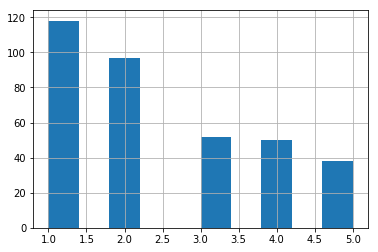

In [52]:
pd.Series(y_binned).hist()

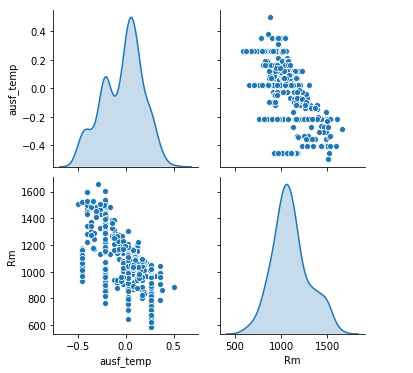

In [119]:
import seaborn as sns
sns.pairplot(df_comp[["ausf_temp", target_column]], diag_kind="kde")

In [126]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling


Epoch: 0, loss:1248493.3750,  mae:1099.9393,  mse:1248493.3750,  val_loss:1268246.6250,  val_mae:1109.5542,  val_mse:1268246.6250,  
....................................................................................................
Epoch: 100, loss:16930.4492,  mae:99.0902,  mse:16930.4492,  val_loss:16922.2441,  val_mae:101.6183,  val_mse:16922.2441,  
....................................................................................................
Epoch: 200, loss:13861.5205,  mae:90.4584,  mse:13861.5205,  val_loss:15772.2441,  val_mae:99.5266,  val_mse:15772.2441,  
....................................................................................................
Epoch: 300, loss:12342.7305,  mae:85.2514,  mse:12342.7305,  val_loss:15745.7324,  val_mae:99.2227,  val_mse:15745.7324,  
....................................................................................................
Epoch: 400, loss:11859.3271,  mae:83.5214,  mse:11859.3271,  val_loss:16284.3809,  val_mae:9

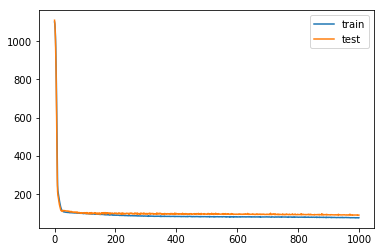


train_max_error: 308.84771728515625
test_max_error: 317.8260498046875

mae: 90.81

Epoch: 0, loss:1252383.2500,  mae:1102.2723,  mse:1252383.2500,  val_loss:1264629.2500,  val_mae:1103.9220,  val_mse:1264629.2500,  
....................................................................................................
Epoch: 100, loss:17435.1953,  mae:101.2879,  mse:17435.1953,  val_loss:24927.7188,  val_mae:101.9333,  val_mse:24927.7188,  
....................................................................................................
Epoch: 200, loss:16001.5410,  mae:97.5863,  mse:16001.5410,  val_loss:22696.9023,  val_mae:99.9251,  val_mse:22696.9023,  
....................................................................................................
Epoch: 300, loss:15216.2109,  mae:95.5708,  mse:15216.2109,  val_loss:18970.1602,  val_mae:98.3764,  val_mse:18970.1602,  
....................................................................................................
Epoch: 4

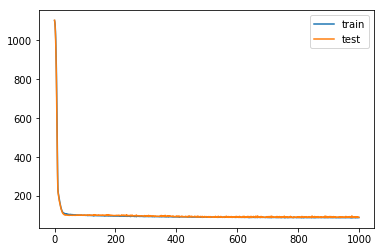


train_max_error: 352.0125732421875
test_max_error: 350.4046630859375

mae: 91.07

Epoch: 0, loss:1255518.7500,  mae:1103.3273,  mse:1255518.7500,  val_loss:1256801.3750,  val_mae:1102.8529,  val_mse:1256801.3750,  
....................................................................................................
Epoch: 100, loss:18628.1367,  mae:102.9069,  mse:18628.1328,  val_loss:18123.5742,  val_mae:100.0379,  val_mse:18123.5762,  
....................................................................................................
Epoch: 200, loss:16405.8340,  mae:98.8208,  mse:16405.8340,  val_loss:14267.1641,  val_mae:89.4311,  val_mse:14267.1641,  
....................................................................................................
Epoch: 300, loss:14797.0664,  mae:94.3899,  mse:14797.0664,  val_loss:12513.0928,  val_mae:82.3980,  val_mse:12513.0928,  
....................................................................................................
Epoch: 40

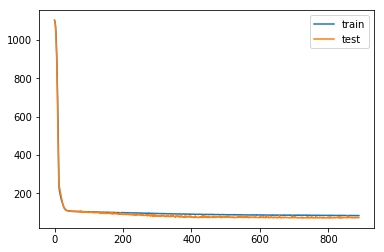


train_max_error: 329.7122802734375
test_max_error: 318.8709716796875

mae: 73.14

Epoch: 0, loss:1256288.3750,  mae:1103.8264,  mse:1256288.3750,  val_loss:1227780.8750,  val_mae:1088.6973,  val_mse:1227780.7500,  
....................................................................................................
Epoch: 100, loss:16893.7441,  mae:97.8198,  mse:16893.7441,  val_loss:25282.1094,  val_mae:124.5616,  val_mse:25282.1094,  
....................................................................................................
Epoch: 200, loss:14793.0098,  mae:91.8124,  mse:14793.0098,  val_loss:21947.3496,  val_mae:116.2591,  val_mse:21947.3496,  
....................................................................................................
Epoch: 300, loss:13108.4717,  mae:87.4399,  mse:13108.4717,  val_loss:18222.9141,  val_mae:110.0555,  val_mse:18222.9141,  
....................................................................................................
Epoch: 4

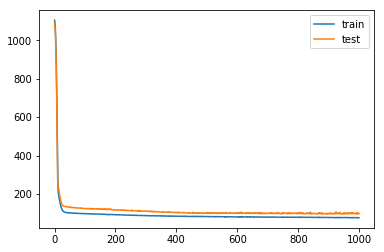


train_max_error: 320.4561767578125
test_max_error: 290.171142578125

mae: 97.92

Epoch: 0, loss:1249994.2500,  mae:1100.7368,  mse:1249994.2500,  val_loss:1277764.6250,  val_mae:1112.8749,  val_mse:1277764.6250,  
....................................................................................................
Epoch: 100, loss:17179.3359,  mae:97.6196,  mse:17179.3359,  val_loss:23710.0918,  val_mae:119.3166,  val_mse:23710.0918,  
....................................................................................................
Epoch: 200, loss:15261.1113,  mae:93.7869,  mse:15261.1113,  val_loss:21401.9727,  val_mae:111.2885,  val_mse:21401.9727,  
....................................................................................................
Epoch: 300, loss:14138.6885,  mae:90.3813,  mse:14138.6885,  val_loss:19958.5898,  val_mae:108.2712,  val_mse:19958.5898,  
....................................................................................................
Epoch: 40

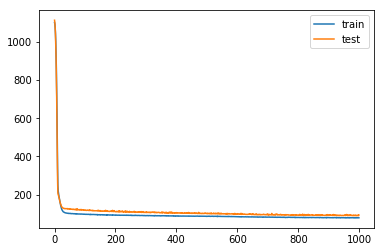


train_max_error: 319.2786865234375
test_max_error: 297.1241455078125

mae: 93.58

Epoch: 0, loss:1253083.2500,  mae:1102.0154,  mse:1253083.2500,  val_loss:1230798.7500,  val_mae:1092.3228,  val_mse:1230798.7500,  
....................................................................................................
Epoch: 100, loss:17174.4707,  mae:98.9102,  mse:17174.4707,  val_loss:16852.2598,  val_mae:102.7234,  val_mse:16852.2598,  
....................................................................................................
Epoch: 200, loss:14249.8057,  mae:91.4378,  mse:14249.8057,  val_loss:17464.9668,  val_mae:107.1227,  val_mse:17464.9668,  
....................................................................................................
Epoch: 300, loss:12837.5703,  mae:87.3697,  mse:12837.5703,  val_loss:14512.3115,  val_mae:98.2148,  val_mse:14512.3115,  
....................................................................................................
Epoch: 40

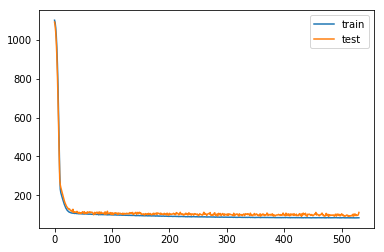


train_max_error: 295.3568115234375
test_max_error: 304.517578125

mae: 111.62

Epoch: 0, loss:1252042.7500,  mae:1101.3246,  mse:1252042.7500,  val_loss:1231920.1250,  val_mae:1094.6132,  val_mse:1231920.1250,  
....................................................................................................
Epoch: 100, loss:16850.1973,  mae:99.3875,  mse:16850.1973,  val_loss:14626.4150,  val_mae:88.3623,  val_mse:14626.4150,  
....................................................................................................
Epoch: 200, loss:13749.7627,  mae:90.1323,  mse:13749.7607,  val_loss:13996.6396,  val_mae:88.2301,  val_mse:13996.6396,  
....................................................................................................
Epoch: 300, loss:12296.0176,  mae:85.0914,  mse:12296.0176,  val_loss:13144.8193,  val_mae:87.4398,  val_mse:13144.8193,  
....................................................................................................
Epoch: 400, lo

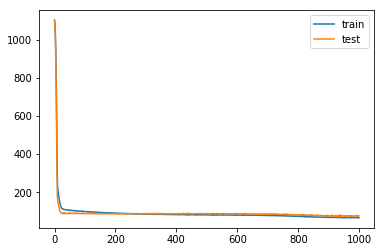


train_max_error: 299.1173095703125
test_max_error: 388.6751708984375

mae: 75.86

Epoch: 0, loss:1257123.8750,  mae:1103.3907,  mse:1257123.8750,  val_loss:1208511.8750,  val_mae:1085.4128,  val_mse:1208512.0000,  
....................................................................................................
Epoch: 100, loss:17780.4004,  mae:101.4874,  mse:17780.4004,  val_loss:16417.9746,  val_mae:97.5166,  val_mse:16417.9746,  
....................................................................................................
Epoch: 200, loss:14707.7178,  mae:93.8314,  mse:14707.7178,  val_loss:15969.1836,  val_mae:96.0291,  val_mse:15969.1836,  
....................................................................................................
Epoch: 300, loss:13131.0859,  mae:89.0938,  mse:13131.0859,  val_loss:15733.8213,  val_mae:94.7950,  val_mse:15733.8213,  
....................................................................................................
Epoch: 400

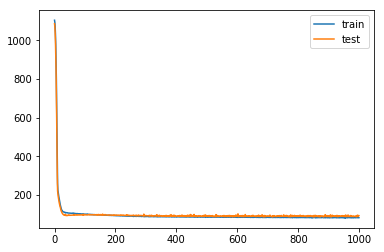


train_max_error: 300.4796142578125
test_max_error: 312.8807373046875

mae: 93.40
90.93 (+/- 11.37)


In [133]:
best_model = None
best_score = 10000000
X_train, X_test = None, None
y_train, y_test = None, None
kfold = StratifiedKFold(n_splits=8, shuffle=True, random_state=51)
cvscores = []
for train, test in kfold.split(X, y_binned):
  # create model
    model = keras.Sequential()
    model.add(layers.Dense(64, activation='relu', input_shape=[len(predictors)]))
    model.add(layers.Dense(64, activation='relu'))
#     model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(1))
    # Compile model
    model.compile(loss='mse', optimizer=tf.keras.optimizers.RMSprop(0.001), metrics=['mae', 'mse'])
    # Fit the model
    early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=100)

    history = model.fit(X[train], y[train], epochs=1000,
                              batch_size=10, verbose=0,
                              validation_data=(X[test], y[test]),
                              callbacks=[early_stop, tfdocs.modeling.EpochDots()])
    scores = model.evaluate(X[test], y[test], verbose=0)
    # evaluate the model
    # learning curves of model accuracy
    plt.plot(history.history['mae'], label='train')
    plt.plot(history.history['val_mae'], label='test')
    plt.legend()
    plt.show()
    train_predictions = model.predict(X[train])
    print()
    print("train_max_error: {}".format(max_error(y[train], train_predictions)))
    test_predictions = model.predict(X[test])
    print("test_max_error: {}".format(max_error(y[test], test_predictions)))
    score = scores[1]
    print("\n{}: {:.2f}".format(model.metrics_names[1], score))
    cvscores.append(score)
    if score < best_score:
        X_train, y_train = X[train], y[train]
        X_test, y_test = X[test], y[test]
        best_model = model
        best_score = score
print("{:.2f} (+/- {:.2f})".format(np.mean(cvscores), np.std(cvscores)))

In [53]:
import xgboost as xgb
from sklearn.metrics import mean_absolute_error
best_model = None
best_score = 10000000
X_train, X_test = None, None
y_train, y_test = None, None
mse_cvscores = []
mae_cvscores = []
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=52)
for train, test in kfold.split(X, y_binned):
    model = xgb.XGBRegressor()
    model.fit(X[train], y[train], eval_set=[(X[test], y[test])], eval_metric='rmse', early_stopping_rounds=3, verbose=0)
    train_predictions = model.predict(X[train])
    test_predictions = model.predict(X[test])
    print("train_mae: {}".format(mean_absolute_error(y[train], train_predictions)))
    score = mean_squared_error(y[test], test_predictions)
    mae = mean_absolute_error(y[test], test_predictions)
    print("test_mae: {}".format(mean_absolute_error(y[test], test_predictions)))
    print("train_max_error: {}".format(max_error(y[train], train_predictions)))
    print("test_max_error: {}".format(max_error(y[test], test_predictions)))
    print()
    mse_cvscores.append(score)
    mae_cvscores.append(mae)
    if score < best_score:
        X_train, y_train = X[train], y[train]
        X_test, y_test = X[test], y[test]
        best_model = model
        best_score = score
print("MSE {:.2f} (+/- {:.2f})".format(np.mean(mse_cvscores), np.std(mse_cvscores)))
print("MAE {:.2f} (+/- {:.2f})".format(np.mean(mae_cvscores), np.std(mae_cvscores)))

train_mae: 12.203112604104634
test_mae: 23.095122691738066
train_max_error: 91.02740478515625
test_max_error: 85.537841796875

train_mae: 4.09248715287431
test_mae: 22.674814548391616
train_max_error: 24.37385253906251
test_max_error: 114.23687744140625

train_mae: 8.34344401705813
test_mae: 20.365072100959765
train_max_error: 53.146697998046875
test_max_error: 81.79057617187499

train_mae: 6.71679062167419
test_mae: 17.326481130580717
train_max_error: 36.911968994140636
test_max_error: 81.19888916015623

train_mae: 15.00727762904947
test_mae: 24.27458934012625
train_max_error: 130.1319580078125
test_max_error: 64.11153564453127

train_mae: 5.122964647159302
test_mae: 20.576575681201483
train_max_error: 24.47674560546875
test_max_error: 125.94479370117188

train_mae: 8.481561760724395
test_mae: 21.593941983214794
train_max_error: 55.64306640625
test_max_error: 82.28042602539062

train_mae: 3.178557646718627
test_mae: 20.202078636708904
train_max_error: 15.943432617187511
test_max_error

In [54]:
def get_parameters(dff):
    cc = dff[chemical_composition].to_dict()
    other = dff[heat_treatment + other_predictors].to_dict()
    params = {
        "chemicalComposition": cc,
    }
    params.update(other)
    return params

min_values = df_before_scaling[predictors].min()
max_values = df_before_scaling[predictors].max()

In [55]:
conf = {
    "modelInput" : predictors,
    "minParams" : get_parameters(min_values),
    "maxParams" : get_parameters(max_values),
    "offset" : 0.5,
}
with open("hb_model_conf.json", 'w') as f:
    json.dump(conf, f)

best_model.save_model("hb_xgb.bin")

Max error 81.19888916015623 for (362.9, 281.7011)


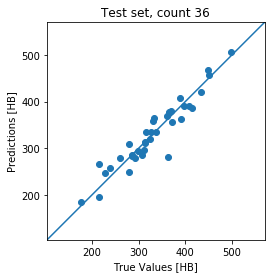

In [47]:
test_predictions = best_model.predict(X_test)
print('Max error {} for {}'.format(max_error(y_test, test_predictions), str(find_max_error(y_test, test_predictions))))

a = plt.axes(aspect='equal')
plt.title('Test set, count {}'.format(y_test.shape[0]))
plt.scatter(y_test, test_predictions)
plt.xlabel('True Values [{}]'.format(target_column))
plt.ylabel('Predictions [{}]'.format(target_column))
lims = [min(y_test)-np.std(y_test), max(y_test)+np.std(y_test)]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

Max error 36.911968994140636 for (277.2, 314.11197)


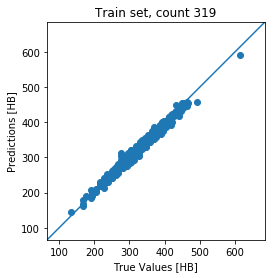

In [58]:
train_predictions = best_model.predict(X_train)
print('Max error {} for {}'.format(max_error(y_train, train_predictions), str(find_max_error(y_train, train_predictions))))

a = plt.axes(aspect='equal')
plt.title('Train set, count {}'.format(y_train.shape[0]))
plt.scatter(y_train, train_predictions)
plt.xlabel('True Values [{}]'.format(target_column))
plt.ylabel('Predictions [{}]'.format(target_column))
lims = [min(y_train)-np.std(y_train), max(y_train)+np.std(y_train)]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

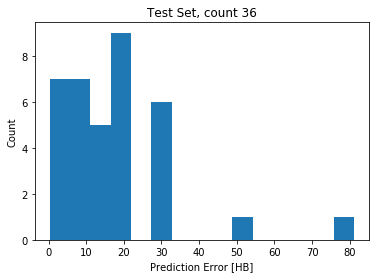

In [60]:
test_error = abs(test_predictions - y_test)
# test_error = abs(test_predictions - y_test.reshape(-1, 1))
plt.hist(test_error, bins = 15)
plt.title('Test Set, count {}'.format(y_test.shape[0]))
plt.xlabel('Prediction Error [{}]'.format(target_column))
_ = plt.ylabel("Count")
plt.show()

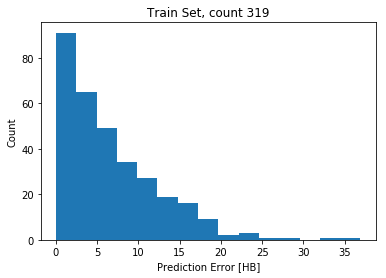

In [61]:
train_error = abs(train_predictions - y_train)
# train_error = abs(train_predictions - y_train.reshape(-1, 1))
plt.hist(train_error, bins = 15)
plt.title('Train Set, count {}'.format(y_train.shape[0]))
plt.xlabel('Prediction Error [{}]'.format(target_column))
_ = plt.ylabel("Count")
plt.show()

In [ ]:
df_new = DataFrame()
df_new[target_column] = df_tmp[target_column]
df_new['{}_predicted'.format(target_column)] = df_tmp.apply(fill, axis = 1, args=(predictors, best_model))
df_new.to_csv('{}_predicted.csv'.format(target_column))


In [ ]:
df_new = DataFrame()
df_new[target_column] = df_tmp[target_column]
df_new['{}_predicted'.format(target_column)] = df_tmp.apply(fill, axis = 1, args=(predictors, best_model))
df_new.to_csv('{}_predicted.csv'.format(target_column))


In [ ]:
# train_error = abs(train_predictions - y_train)
train_error = abs(train_predictions - y_train.reshape(-1, 1))
plt.hist(train_error, bins = 15)
plt.title('Train Set, count {}'.format(y_train.shape[0]))
plt.xlabel('Prediction Error [{}]'.format(target_column))
_ = plt.ylabel("Count")
plt.show()

In [ ]:
df_new = DataFrame()
df_new[target_column] = df_tmp[target_column]
df_new['{}_predicted'.format(target_column)] = df_tmp.apply(fill, axis = 1, args=(predictors, best_model))
df_new.to_csv('{}_predicted.csv'.format(target_column))


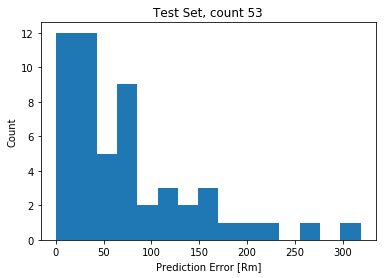

In [140]:
df_new = DataFrame()
df_new[target_column] = df_tmp[target_column]
df_new['{}_predicted'.format(target_column)] = df_tmp.apply(fill, axis = 1, args=(predictors, best_model))
df_new.to_csv('{}_predicted.csv'.format(target_column))


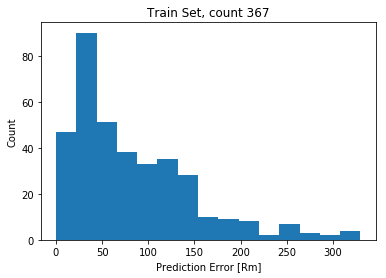

In [141]:
# train_error = abs(train_predictions - y_train)
train_error = abs(train_predictions - y_train.reshape(-1, 1))
plt.hist(train_error, bins = 15)
plt.title('Train Set, count {}'.format(y_train.shape[0]))
plt.xlabel('Prediction Error [{}]'.format(target_column))
_ = plt.ylabel("Count")
plt.show()

In [125]:
df_new = DataFrame()
df_new[target_column] = df_tmp[target_column]
df_new['{}_predicted'.format(target_column)] = df_tmp.apply(fill, axis = 1, args=(predictors, best_model))
df_new.to_csv('{}_predicted.csv'.format(target_column))
